# Introducción a Graph Convolutions

Uno de los tipos de datos más poderosos para herramientas de deep learning son los "graph convolutions". La razon es por que en general, las moléculas pueden ser de forma natural vistas como grafos (modelo de esferas y varillas, donde las esferas serían los vértices y las varillas las aristas)

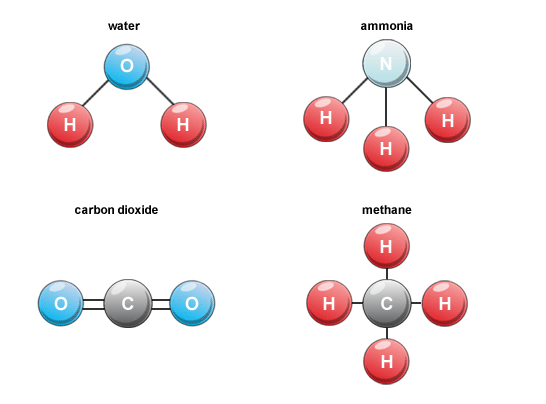

## Que son los Graph Convolutions

En una Red Neuronal Convolucional (CNN) estándar, se procesan imágenes, que se representan como una cuadrícula de píxeles. Cada píxel tiene un vector de valores de datos, como los canales de color rojo, verde y azul (RGB). Los datos pasan a través de una serie de capas convolucionales. Cada capa combina los datos de un píxel y sus vecinos para producir un nuevo vector de datos para el píxel. Las capas iniciales detectan patrones locales de pequeña escala, mientras que las capas posteriores detectan patrones más grandes y abstractos. A menudo, las capas convolucionales se alternan con capas de agrupación (pooling) que realizan operaciones como el máximo o el mínimo sobre regiones locales.

Las convoluciones en grafos son similares, pero operan en una estructura de grafo en lugar de una cuadrícula de píxeles. Comienzan con un vector de datos para cada nodo del grafo, por ejemplo, las propiedades químicas del átomo que representa ese nodo. Las capas de convolución en grafos, al igual que las capas convolucionales en una CNN, combinan información de nodos conectados (por ejemplo, átomos que están unidos entre sí) para producir un nuevo vector de datos para cada nodo.

**En resumen:**
* Las CNN procesan imágenes como cuadrículas de píxeles con canales de datos, mientras que las convoluciones en grafos operan en estructuras de grafo con nodos que tienen vectores de datos asociados.

* En ambas arquitecturas, las capas convolucionales combinan información local de los elementos vecinos para detectar patrones.

## Entrenando un GraphConvModel

Usaremos el dataset de MoleculeNEt de Tox21. Featurizaremos los datos como GraphConv

In [1]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\alloh\Miniconda3\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
[10:14:07] WARNING: not removing hydrogen atom without neighbors
[10:14:26] WARNING: not removing hydrogen atom without neighbors


Procedemos a entrenar un modelo con este dataset. DeepChem tiene una clase llamada GraphConvModel que envuelve un estandar de la arquitectura graph convolutional

In [2]:
n_tasks = len(tasks) #Obtenemos el numero de tareas (salidas // variables a predecir)
model = dc.models.GraphConvModel(n_tasks, mode='classification') #especificamos el numero de tareas
model.fit(train_dataset, nb_epoch=50) #Entrenamos el modelo

0.2760580825805664

Ahora vamos a intenter medir el rendimiento del modelo. Para ello, dc.metrics contiene una colección de metricas ya predefinidas. Para este dataset en concreto, es común usar el AUC score. Esto ya esta disponible en DeepChem.

**Para medir el rendimiento, usaremos la función model.evaluate()**

In [3]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))

Training set score: {'roc_auc_score': 0.972663773419424}
Test set score: {'roc_auc_score': 0.7002314541035733}


### Desglose de las Capas en un Modelo de Convolución de Grafos

Los resultados son bastante buenos y `GraphConvModel` es muy fácil de usar. Pero, ¿qué sucede con nuestro modelo? ¿Podemos construir `GraphConvModel` nosotros mismos? ¡Por supuesto! DeepChem proporciona capas de Keras para todas las operaciones involucradas en una convolución de grafos. Vamos a aplicar las siguientes capas de DeepChem.

#### Capa GraphConv:
Esta capa implementa la convolución de grafos. La convolución de grafos combina de manera no lineal los vectores de características por nodo con los vectores de características de los nodos vecinos. Esto "mezcla" información en vecindarios locales de un grafo.

#### Capa GraphPool:
La capa GraphPool es análoga a las capas de max-pooling utilizadas en las redes convolucionales convencionales, pero opera en grafos en lugar de imágenes. Esta capa se utiliza para reducir la dimensionalidad de los vectores de características en un grafo.

En la práctica, la capa GraphPool selecciona la característica más importante de un vecindario local de nodos en el grafo, de manera similar a cómo una capa de max-pooling selecciona la característica más importante en una región local de una imagen. Esto puede ayudar a reducir la complejidad del modelo y extraer las características más relevantes del grafo.

#### Capa GraphGather:
La capa GraphGather se utiliza en redes neuronales convolucionales en grafos (GCNs) para transformar los vectores de características de los nodos en un grafo en un solo vector que representa el grafo en su conjunto. En otras palabras, toma los vectores de características de los nodos y los combina para obtener un resumen de alto nivel de todo el grafo.

En un ejemplo práctico, si estás trabajando con una molécula representada como un grafo, cada nodo podría representar un átomo con sus propias características químicas. La capa GraphGather se utilizaría al final de la red para tomar todas las características atómicas y combinarlas en un único vector que representa la molécula en su totalidad.

Además de esto, aplicaremos capas estándar de redes neuronales como 
* **Dense:** Todas las neuronas conectadas entre si
* **BatchNormalization:** Aplicamos transformación que mantiene la media de la salida cercana a 0 y la desviacióne estandar de la salida a 1 
* **Capa Softmax:** La capa Softmax es ampliamente utilizada en la capa de salida de una red neuronal cuando se realiza una tarea de clasificación multiclase, ya que asigna una probabilidad a cada clase y permite seleccionar la clase con la probabilidad más alta como la predicción final. También es importante en la función de pérdida de la red para calcular el error durante el entrenamiento.



In [4]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers

batch_size = 100

class MyGraphConvModel(tf.keras.Model):
    
    #Función de inicialización de capas del modelo
    def __init__(self):
        super(MyGraphConvModel, self).__init__() #Llamamos al init de la clase padre
        self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh) 
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(n_tasks*2)
        self.logits = layers.Reshape((n_tasks, 2))
        self.softmax = layers.Softmax()
    
    #Función de procesamiento de los inputs (capas por donde viajan los inputs hasta obtener el resultado final)
    def call(self, inputs):
        gc1_output = self.gc1(inputs)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

        gc2_output = self.gc2([gp1_output] + inputs[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + inputs[1:])

        logits_output = self.logits(self.dense2(readout_output))
        return self.softmax(logits_output)

En el modelo que hemos definido anteriormente podemos ver como tenemos dos bloques convolucionales que consisten en un GraphConv, seguido de una batch normalization y de un GraphPool para realizar el MaxPooling. Terminamos con una capa densa, otra de batch normalization, un GraphGather para combinar los datos de todos los diferentes nodos y una capa final densa para producir el output global.

Crearemos ahora un modelo DeepChem que envolverá al modelo Keras que acabamos de crear. Estableceremos la función de perdida para que el modelo conozca el objetivo a minimizar.

In [5]:
model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.CategoricalCrossEntropy())

Las entradas de este modelo serán GraphConvolution. Es una descripción completa de cada molécula, incluyendo una lista de nodos (los átomos) y una descripción de cuales estan unidos unos con otros.

In [7]:
test_dataset.X[0]

### Conversión de Objetos ConvMol a Matrices Numéricas

Los modelos esperan arrays de números como entradas en lugar de objetos Python. Por lo tanto, debemos convertir los objetos ConvMol en el conjunto específico de arrays esperado por las capas GraphConv, GraphPool y GraphGather. Afortunadamente, la clase ConvMol incluye el código necesario para hacer esto, así como para combinar todas las moléculas en un lote para crear un conjunto único de arrays.

El siguiente código crea un **generador Python que, dado un lote de datos, genera listas de entradas, etiquetas y pesos, cuyos valores son arrays de NumPy.** 
* atom_features que contiene un vector de características de longitud 75 para cada átomo. 
* Las demás entradas son necesarias para admitir el minibatching en TensorFlow:
* degree_slice es una conveniencia de indexación que facilita la ubicación de átomos de todas las moléculas con un grado dado. 
* membership determina la pertenencia de los átomos a las moléculas (el átomo i pertenece a la molécula membership[i]). 
* deg_adjs es una lista que contiene listas de adyacencia agrupadas por el grado del átomo.

Código Fuente: https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py

In [15]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
import numpy as np

#Función que toma como entrada un batch de datos y genera listas cuyos valores son inputs, labels y weights siendo sus
#valores arrays de NumPy.
def data_generator(dataset, epochs=1):
    
    '''
    Iteramos a través de lotes de datos en el conjunto de datos proporcionado. Los lotes incluyen características (X_b), 
    etiquetas (y_b), pesos (w_b), y posiblemente identificadores (ids_b). Los lotes se obtienen utilizando el método 
    iterbatches de DeepChem (Esto divide el conjunto de datos en lotes más pequeños (batches)).
    '''
    for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs,
                                                                   deterministic=False, pad_batches=True)):
        
        multiConvMol = ConvMol.agglomerate_mols(X_b) #Concatena una lista de objetos ConvMol en un solo objeto mol.
                                                     #mols representa una lista de objetos ConvMol
        inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
        
        #Itera a través de las listas de adyacencia de grados (degree adjacency lists) 
        #de las moléculas y agrega estas listas a la lista inputs.
        for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
            inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
        
        #Convierte las etiquetas y_b en codificación one-hot utilizando 
        #la función to_one_hot de DeepChem. Luego, reformatea la matriz resultante.
        
        labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
        #Agrega los pesos a la lista Weights.
        weights = [w_b]
        
        #La función es un generador, por lo que devuelve un conjunto de datos inputs, labels y weights en cada iteración
        #en lugar de almacenarlos en la memoria. Esto permite un procesamiento eficiente de grandes conjuntos de datos.
        
        yield (inputs, labels, weights)

Ahora entrenaremos usando el fit_generator(generator) que usara el generador definido para entrenar el modelo

In [12]:
data_generator(train_dataset, epochs=50)

<generator object data_generator at 0x000001CF551D0E40>

In [10]:
model.fit_generator(data_generator(train_dataset, epochs=50))

0.24936410903930664

Evaluamos su rendimiento

In [11]:
print('Training set score:', model.evaluate_generator(data_generator(train_dataset), [metric], transformers))
print('Test set score:', model.evaluate_generator(data_generator(test_dataset), [metric], transformers))

Training set score: {'roc_auc_score': 0.8282089589455955}
Test set score: {'roc_auc_score': 0.6418380737789403}
